# **Classificatore forme**

Il seguente progetto implementa la classificazione delle forme geometriche fornite ricorrendo a diversi approcci in fatto di rappresentazione dei dati forniti e di modelli di predizione. 
* **Rappresentazione dei dati**: per quanto riguarda la descrizione utilizzata al fine della classificazione si ricorre sia all'utilizzo della rappresentazione originale fornita dalla traccia che ad una rappresentazione alternativa che comunque non ricorre ad alterazioni o aggiunte ai dati forniti. In particolare vengono proposti approcci di Feature Extraction (PCA) e Feature Selection (Feature Importance) sui dati in forma originale, al fine di ridurre la dimensionalità dei campioni e quindi un'alleggerimento del carico computazionale nella fase di addestramento, ma anche al fine di restituire informazioni circa le quantità di informazioni contenute nelle features.
La rappresentazione alternativa invece propone di rappresentare ogni campione attraverso le distanze tra i punti consecutivi che lo compongnono, andandole a calcolare proprio a partire dai punti estratti dalla funzione generatrice dei campioni. Questa strategia oltre a dare l'eventuale possibilità di calcolare nuove feature (ad esempio il perimetro come somma delle distanze locali), permette di rappresentare un campione con un numero decisamente inferiore di feature ovvero $n_{punti} - 1$ anziché $2 \cdot n_{punti} $ come nel caso di partenza.
* **Model Selection**: i modelli di classificazione scelti sono Logistic Regression, Support Vector Machine e Multi Layer Perceptron. La Model Selection è stata effettuata utilizzando il modello GridSearchCV di ScikitLearn che permette, per ogni classificatore proposto, di effettuare una "ricerca a griglia" all'interno dello spazio degli iperparametri proposti per ognuno di essi; dunque tale modello andrà ad effettuare una cross-validation sul Training Set fornito con un certo numero di fold e provare ogni possibile configurazione di iperparametri per poi restituire quella che restituisce un punteggio migliore, che in questo caso corrisponde all'accuracy sui vari validation set generati.

---

## Importazione librerie necessarie

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from time import time
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neural_network  import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics         import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.spatial import ConvexHull
from sklearn.metrics import roc_curve, auc
from itertools import combinations
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Generazione

In [8]:
def to_stringa(punti, forma):
    return ";".join(f"{x:.3f}:{y:.3f}" for x, y in punti)+','+forma

def genera_segmento(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Calcola le coordinate dei due estremi del segmento
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    # Interpolazione lineare tra i due estremi per ottenere i punti
    t = np.linspace(0, 1, n_punti)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    # Aggiunta di rumore gaussiano alle coordinate
    x += np.random.normal(0, rumore_std, size=n_punti)
    y += np.random.normal(0, rumore_std, size=n_punti)
    # Restituisce un array Nx2 con i punti generati
    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)

def genera_croce(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    # Primo segmento (angolo theta)
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    t = np.linspace(0, 1, n_punti//2)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    x += np.random.normal(0, rumore_std, size=n_punti//2)
    y += np.random.normal(0, rumore_std, size=n_punti//2)

    # Secondo segmento (angolo theta + 90°)
    x1 = x0 - l * np.sin(theta)
    y1 = y0 + l * np.cos(theta)
    x2 = x0 + l * np.sin(theta)
    y2 = y0 - l * np.cos(theta)
    t = np.linspace(0, 1, n_punti//2)
    xx = x1 + t * (x2 - x1)
    yy = y1 + t * (y2 - y1)
    xx += np.random.normal(0, rumore_std, size=n_punti//2)
    yy += np.random.normal(0, rumore_std, size=n_punti//2)

    # Unisce i punti dei due segmenti
    x = np.concatenate([x, xx])
    y = np.concatenate([y, yy])

    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)



def genera_ellisse(a=1.0, b=0.5, centro=(0, 0), angolo=0.0, n_punti=100, rumore_std=0.0):
    t = np.linspace(0, 2 * np.pi, n_punti)
    x = a * np.cos(t)
    y = b * np.sin(t)

    # Rotazione
    x_rot = x * np.cos(angolo) - y * np.sin(angolo)
    y_rot = x * np.sin(angolo) + y * np.cos(angolo)

    # Traslazione
    x_finale = x_rot + centro[0]
    y_finale = y_rot + centro[1]

    # Rumore
    x_finale += np.random.normal(0, rumore_std, size=n_punti)
    y_finale += np.random.normal(0, rumore_std, size=n_punti)

    return np.stack([x_finale, y_finale], axis=1)


def genera_rettangolo(larghezza=1.0, altezza=0.5, centro=(0, 0), angolo=0.0,
            rumore_std=0.0, n_punti=100):
    if n_punti < 4:
        raise ValueError("n_punti deve essere almeno 4")

    # Vertici base
    w, h = larghezza / 2, altezza / 2
    vertici = np.array([
        [-w, -h],
        [ w, -h],
        [ w,  h],
        [-w,  h]
    ])

    # Lati e lunghezze
    lati = [(vertici[(i+1) % 4] - vertici[i]) for i in range(4)]
    lunghezze = np.array([np.linalg.norm(l) for l in lati])
    proporzioni = lunghezze / lunghezze.sum()

    # Distribuzione dei punti
    n_per_lato = np.floor(proporzioni * n_punti).astype(int)
    restante = n_punti - n_per_lato.sum()
    for i in range(restante):
        n_per_lato[i % 4] += 1

    # Generazione dei punti
    punti = []
    for i, n in enumerate(n_per_lato):
        start = vertici[i]
        end = vertici[(i + 1) % 4]
        t_values = np.linspace(0, 1, n, endpoint=False)
        lato = np.outer(1 - t_values, start) + np.outer(t_values, end)
        punti.append(lato)
    punti = np.vstack(punti)

    # Rotazione, traslazione e rumore
    R = np.array([
        [np.cos(angolo), -np.sin(angolo)],
        [np.sin(angolo),  np.cos(angolo)]
    ])
    punti = punti @ R.T
    punti += np.array(centro)
    punti += np.random.normal(0, rumore_std, punti.shape)

    return punti

### Generazione Dataset
- Le funzioni di generazione del dataset fornite vanno a generare *n_shapes* campioni di ogni tipo di forma considerato, andandole a generare come liste di punti (coppie di coordinate (x,y)) e raccolte in un'unica lista che è il dataset; poi viene anche restituita la lista y delle etichette di ogni forma generata [0 = ellisse, 1 = rettangolo, 2 = segmento, 3 = croce].

In [9]:
def genera_campioni(n_shapes = 100, n_punti = 50, rumore_std_bound=0):

    X, y = [], []  # Liste per memorizzare i campioni e le etichette

    # Genera ellissi
    for _ in range(n_shapes):
        a = np.random.uniform(0.5, 3.0)                  # semiasse maggiore
        b = np.random.uniform(0.3, a)                    # semiasse minore
        centro = (np.random.uniform(-5, 5), np.random.uniform(-5, 5))  # centro casuale
        angolo = np.random.uniform(0, 2 * np.pi)         # rotazione casuale
        rumore = np.random.uniform(0.0, rumore_std_bound)  # rumore casuale
        punti = genera_ellisse(a, b, centro, angolo, n_punti=n_punti, rumore_std=rumore)  # genera punti
        X.append(punti)
        y.append(0)  # 0 = ellisse

    # Genera rettangoli
    for _ in range(n_shapes):
        punti = genera_rettangolo(
            larghezza=np.random.uniform(0.5, 3.0),       # larghezza casuale
            altezza=np.random.uniform(0.5, 2.0),         # altezza casuale
            centro=(np.random.uniform(-5, 5), np.random.uniform(-5, 5)),  # centro casuale
            angolo=np.random.uniform(0, 2*np.pi),        # rotazione casuale
            rumore_std = np.random.uniform(0.0, rumore_std_bound),        # rumore casuale
            n_punti = n_punti
        )
        X.append(punti)
        y.append(1) # 1 = rettangolo

    # Genera segmenti
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_segmento(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(2)
        
    # Genera croci (due segmenti ortogonali)
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_croce(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(3)  # 3 = croce
        

    return np.array(X), np.array(y)  # restituisce array di campioni e etichette


Rappresentazione vettoriale originale proposta dalla traccia del progetto consistente nella sequenza di coordinate di ogni punto di una forma

In [24]:
def get_vector_representation(X):
    return np.array([list(x.flatten()) for x in X])

Rappresentazione vettoriale alternativa consistente nel calcolo delle distanze locali dei punti di una forma.
- A tal fine si vanno a calcolare le differenze tra punti consecutivi forniti dalla funzione `genera_campioni` sotto forma di coppie di coordinate, per poi calcolarne la 
norma di ognuno
- Questa rappresentazione alternativa permette di ottenere una descrizione del dataset molto più sintetica rispetto a quella originale in quanto vengono utilizzate un numero di feature per ogni forma pari a *(n_punti - 1)* anziché *2 * n_punti*


In [ ]:
def get_vector_representation_2(X):
    n_punti_forma = X.shape[1]
    X_reshaped = X.reshape(-1, n_punti_forma, 2)      # converte X di forma (n_shape*n_punti,2) in X_reshaped di forma(n_shape, n_punti, 2)
    vettori = X_reshaped[:, 1:, :] - X_reshaped[:, :-1, :]  # differenze tra punti consecutivi
    distanze = np.linalg.norm(vettori, axis=2)             # norma lungo asse delle componenti (x,y)
     
    return distanze

In [25]:
def ottieni_features(X):
    return get_vector_representation(X)

In [11]:
def ottieni_features_2(X):
    return get_vector_representation_2(X)

In [26]:
labels = ['ellisse', 'rettangolo', 'segmento', 'croce']

---

In [ ]:
X_flat = np.array([shape.flatten() for shape in X])

# 2) Genera i nomi delle colonne
n_punti = X.shape[1]
cols_xy = []
for i in range(n_punti):
    cols_xy += [f'x{i}', f'y{i}']

# 3) Costruisci df_flat e assegna la label
df_flat = pd.DataFrame(X_flat, columns=cols_xy)  
df_flat['label'] = y

In [ ]:
df_flat.to_csv('dataset_flat.csv', index=False) #Esportazione del dataset flat

---

# 1. **Feature engineering** su dataset originale

## Costruzione dataset
Si va a generare il dataset ricorrendo alla rappresentazione delle forme tramite sequenza di coordinate "appiattita"

* Costruiamo il dataset `flat` richiamando la funzione originale `ottieni_features`

In [13]:
X, y = genera_campioni(n_shapes=1000, n_punti=100, rumore_std_bound=0.00001)

In [27]:
X_flat = ottieni_features(X) # rappresentazione tramite vettore appiattito

## Splitting del dataset

Andiamo ad effettuare lo splitting del dataset per ottenere il training set `(X_train, y_train)` ed il test set `(X_test, y_test)` ricorrendo ad una proporzione *70%/30%*

In [28]:
# 1) Split iniziale: train+val vs test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.3, random_state=42, stratify=y
)


Print delle dimensioni di ogni sottoinsieme:

In [29]:
print("Shape di X_train:", X_train.shape)
print("Shape di X_test:", X_test.shape)

Shape di X_train: (2800, 200)
Shape di X_test: (1200, 200)


---

## Standardizzazione delle Features e applicazione del metodo della PCA
- Si va prima di tutto a standardizzare i valori delle Features per tenere i valori di ogni componente sulla stessa scala;
- Dopodiché si applica il metodo della PCA, tramite implementazione del codice visto a lezione, al fine di ridurre la dimensionalità di ogni campione e quindi facilitare la fase di Fitting del modello predittivo.

In [30]:
# Definizione funzione get_eigen(A) necessaria al calcolo della matrice di covarianza ed i relativi autovettori e autovalori

def get_eigen(A):
    # calcola la media per ogni colonna (feature)
    means = np.mean(A, axis=0)
    # sottrae la media (lungo le colonne): ogni feature ora ha media zero
    M = (A - means)
    # calcola la matrice di covarianza delle righe di A
    c = np.cov(M, rowvar=0)
    # calcola autovalori e autovettori della matrice di covarianza
    [evals, evects] = np.linalg.eig(c)
    # ottiene gli indici degli autovalori ordinati in modo decrescente
    idx = np.argsort(evals)[::-1]
    # ordina gli autovettori (colonne di evects) secondo gli autovalori ordinati
    evects = evects[:, idx]
    # ordina gli autovalori in modo decrescente
    evals = evals[idx]
    return evals, evects, M

# Definizione della funzione pca che va a creare la base formata dagli autovettori e ad effettuare le proiezioni della matrice di covarianza su tale base.

def pca(M, vec, numpc=0):
    # Estrae i primi 'numpc' autovettori come base dello spazio ridotto
    basis = vec[:, range(numpc)]
    # Proietta i dati centrati nello spazio delle componenti principali
    projections = np.dot(M, basis)
    # Restituisce la base e le proiezioni
    return basis, projections

* Costruzione di uno scaler dalla libreria di Scikitlearn e trasformazione sia del Training Set che del Test Set

In [31]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

* Applicazione della PCA ad entrambi i sotto-dataset specificando un numero di componenti principali da mantenere pari a **20**

In [42]:
numpc = 11

# Calcolo autovalori, autovettori e M_train centrate sulla media di X_train_std
evals_train, evects_train, M_train = get_eigen(X_train_std)

# Proietto TRAIN
basis_train, proiezioni_train = pca(M_train, evects_train, numpc=numpc)

# ------- 4. PCA sul TEST usando la STESSA base e media del TRAIN -------
# Ricostruisco M_test sottraendo la media di X_train_std
means_train = np.mean(X_train_std, axis=0)
M_test = X_test_std - means_train

# Richiamo pca con vec = evects_train (gli stessi usati per il train)
basis_test, proiezioni_test = pca(M_test, evects_train, numpc=numpc)

* Rappresentazione grafica comparando le figure originali con quelle ricostruite utilizzando le componenti principali estratte

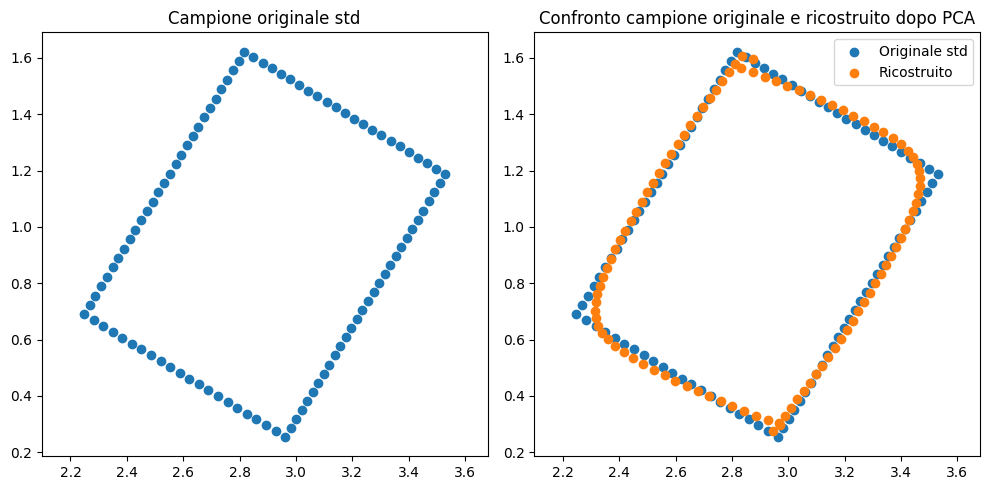

In [48]:

i = np.random.randint(low=1, high=1000)


# 1) ricostruzione dell'intero train set in scala standard
M_recon = proiezioni_train.dot(basis_train.T)                     # dati centrati ricostruiti
means_train = np.mean(X_train_std, axis=0)                        # media del train set standardizzato
X_recon_std = M_recon + means_train                               # riaggiungo la media
# se vuoi riportare nello spazio originale:
X_recon = scaler.inverse_transform(X_recon_std)                  

# 2) estrai il campione originale e quello ricostruito
orig_sample  = X_train[i].reshape(-1, 2)
recon_sample = X_recon[i].reshape(-1, 2)

# 3) plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# subplot 1: campione originale
ax1.scatter(orig_sample[:,0], orig_sample[:,1])
ax1.set_title("Campione originale std")
ax1.axis('equal')

# subplot 2: confronto originale vs ricostruito
ax2.scatter(orig_sample[:,0],  orig_sample[:,1],  label="Originale std")
ax2.scatter(recon_sample[:,0], recon_sample[:,1], label="Ricostruito")
ax2.set_title("Confronto campione originale e ricostruito dopo PCA")
ax2.axis('equal')
ax2.legend()

plt.tight_layout()
plt.show()

---

## Feature selection e valutazione


- Per applicare la Feature Selection si ricorre all'utilizzo del modello `Random Forest` che permette di restituire la misura di *importanza* delle feature del dataset basandosi sulla somma totale di *information gain* relativa ad ogni feature. 
- Dunque verrà specificato il numero di Decision Tree all'interno della foresta e poi addestrato il modello per raccogliere le feature che vengono scelte in base ad una soglia minima `importance_threshold` che specifica la percentuale di importanza che una feature deve avere per poter essere mantenuta.

In [56]:
rf = RandomForestClassifier(n_estimators=50, random_state=0)
rf.fit(X_train, y_train)

,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


* Dopo aver addestrato il modello sul train set, otteniamo le features più importanti, ottenute automaticamente dall'addestramento stesso

In [57]:
importances_rf = rf.feature_importances_

* Con questo metodo calcoliamo la soglia basata sul `percentile`:

Percentile 10% → trattandosi di 10 componenti, il 10° percentile corrisponde all’importanza del secondo elemento ordinato;
quindi mantieni le componenti dall’indice del 2° valore in poi (top 8 su 10 = 80 %).
e

In [58]:
importance_threshold = np.percentile(importances_rf, 10)  # top 90%
mask = importances_rf >= importance_threshold
print("Componenti mantenute:", np.where(mask)[0]) #Indicizzazione X[:, mask] filtra le colonne, riducendo dimensionalità e mantenendo solo quelle ritenute “importanti”.
X_train_sel = X_train[:, mask]
X_test_sel  = X_test[:,  mask]

Componenti mantenute: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  39  40  41  42  43  45  47  48  49  51  52  53  55  57  59  61
  63  64  65  66  67  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 141 143 144 145 147 149 151 153 154 155 157 159 161 162
 163 164 165 166 167 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199]


Rappresentazione grafica della ricostruzione delle forme utilizzando solo le feature estratte dalla precedente classificazione

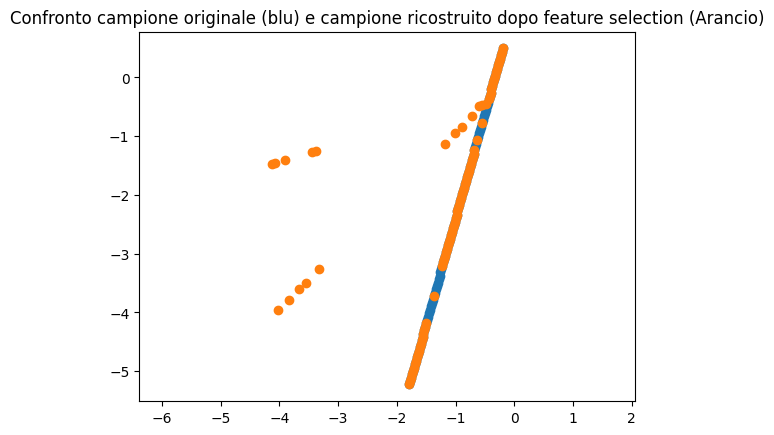

In [65]:
i = np.random.randint(low=1, high=1000)

projected_example_train = X_train_sel[i]
transformed_example_train = projected_example_train.reshape(-1,2)

orig = X_train[i].reshape(-1,2)
x  = [orig[i][0] for i in range(orig.shape[0])]
y  = [orig[i][1] for i in range(orig.shape[0])]
ax1 = plt.subplot()
ax1.set_title("Campione originale")
ax1.axis('equal')
ax1.scatter(x,y)

x_recon  = [transformed_example_train[i][0] for i in range(transformed_example_train.shape[0])]
y_recon  = [transformed_example_train[i][1] for i in range(transformed_example_train.shape[0])]
ax2 = plt.subplot()
ax2.set_title("Confronto campione originale (blu) e campione ricostruito dopo feature selection (Arancio)")
ax2.axis('equal')
ax2.scatter(x_recon,y_recon)

---

## Estrazione e valutazione di nuove features

**Costruiamo un nuovo dataset contenente nuove features per ogni forma. Queste nuove features sono:**
* Distanza dal centroide
* Perimetro
* Area
* Distanza tra i punti estremi
* Compattezza

In [ ]:
def extract_geometric_features(pts):
    """
    pts: array (n_punti, 2)
    Restituisce un dict con le feature geometriche.
    """
    # 1. Centroid
    cx, cy = pts.mean(axis=0)
    # distanze dal centroide
    dists = np.linalg.norm(pts - (cx, cy), axis=1)
    dist_mean = dists.mean()
    dist_std  = dists.std()

    # 2. Perimetro
    diffs = np.diff(pts, axis=0, append=pts[:1])
    perimeter = np.linalg.norm(diffs, axis=1).sum()

    # 3. Area (shoelace)
    x, y = pts[:,0], pts[:,1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

    # 5. Extreme distances
    # (costo O(n^2), per n~100 va bene)
    dists_all = [np.linalg.norm(p-q) for p, q in combinations(pts, 2)]
    d_max = max(dists_all)
    d_min = min(dists_all)

    # 7. Compactness
    compactness = 4*np.pi*area/(perimeter**2) if perimeter>0 else 0

    feats = {
        'dist_mean': dist_mean,
        'dist_std':  dist_std,
        'perimeter': perimeter,
        'area':      area,
        'd_max':     d_max,
        'd_min':     d_min,
        'compactness': compactness,
    }
    return feats
    

* Costruiamo ora il nuovo dataset 

In [ ]:
features_list = []
for shape, lbl in zip(X, y):
    feats = extract_geometric_features(shape)
    feats['label'] = lbl
    features_list.append(feats)
df_geo = pd.DataFrame(features_list) 

In [ ]:
df_geo.to_csv('dataset_geo.csv', index=False) # Esportazione del dataset con le feature geometriche

---

## Classificazione a partire dalla rappresentazione alternativa delle forme

Si va a generare il dataset relativo alla rappresentazione alternativa implementata in `get_vector_representation_2(X)` e poi alla valutazione della classificazione tramite utilizzo di un modello MLP per vedere come si comporta.

In [15]:
X_alternative = ottieni_features_2(X)
print("Shape di X_alternative:", X_alternative.shape)

Shape di X_alternative: (4000, 99)


In [16]:
X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(
    X_alternative, y
)

* Standardizziamo le componenti, poichè presentano valori diversi tra loro

In [17]:
X_train_alt_std = StandardScaler().fit_transform(X_train_alt)
X_test_alt_std = StandardScaler().fit_transform(X_test_alt)

- Utilizzo del modello **GridSearch** per implementare la **Cross Validation** e quindi al *fine tuning* del modello per trovare il modello migliore in funzione dei valori degli iperparametri proposti.
- In questo caso è stato scelto di utilizzare lo stesso modello trovato per il caso precedente in modo tale da comparare quanto incidono sulla classificazione finale i due approcci diversi di descrizione dei dati.

In [18]:
param_grid_mlp_alt = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['logistic'],
    'solver': ['sgd'],  # stochastic gradient descent
    'alpha': [0.001, 0.01, 0.1],    # moltiplicatore del fattore L2 di regolarizzazione per penalizzazione overfitting
    'learning_rate_init': [0.01, 0.1],
    'learning_rate': ['constant'], 
    'batch_size': [30, 50, 70],
    'max_iter': [100, 200, 300]
}

In [19]:
gs_mlp_alt = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_mlp_alt,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

Costo complessivo di complessità della rete neurale MLP: O(n * h * (t + d)) dove n=4000, h=50, t=4 e d=99

In [20]:
start_time = time()
print("Tuning MLP...")
gs_mlp_alt.fit(X_train_alt_std, y_train_alt)
end_time = time()

Tuning MLP...


In [21]:
minuti_impiegati = (end_time-start_time)/60
print(f"Tempo trascorso in minuti: {minuti_impiegati:.2f}")
print("\nBest MLP params for alt:", gs_mlp_alt.best_params_)
print("Best accuracy:",      gs_mlp_alt.best_score_)

Tempo trascorso in minuti: 12.98

Best MLP params for alt: {'activation': 'logistic', 'alpha': 0.001, 'batch_size': 70, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'}
Best accuracy: 0.9906689883325398


- Predizione degli elementi nel Test Set e valutazione tramite le principali misure di scoring e Confusion Matrix

In [78]:
y_pred_mlp_alt = gs_mlp_alt.predict(X_test_alt_std)
print("Val Accuracy: ", accuracy_score(y_test_alt, y_pred_mlp_alt))
print(classification_report(y_test_alt, y_pred_mlp_alt))

Val Accuracy:  0.986
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       229
           1       1.00      1.00      1.00       260
           2       0.95      1.00      0.97       267
           3       1.00      0.97      0.98       244

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



Si può osservare come la predizione da parte di questo modello addestrato sul dataset rappresentato alternativamente performi meglio rispetto a quello addestrato sul dataset originale, a scapito di un maggiore tempo impiegato nella fase di fitting.

**Confusion Matrix**

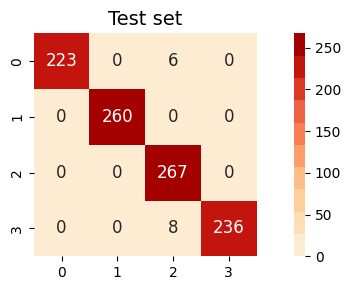

In [23]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test_alt, y_pred_mlp_alt),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

---

# 2. **Costruzione e valutazione di classificatori**

Verranno istanziati e addestrati 3 modelli tramite GridSearchCV che permette di addestrare i modelli su diverse configurazioni possibili di iperparametri al fine di restituire poi quella che produce il maggiore score di *accuracy*, riccorrendo all'utilizzo del metodo di Cross Validation. I modelli utilizzati sono:
- **Logistic Regression** con iperparametro `multi_class=[ovr, multinomial]` per permettere la classificazione multiclasse;
- **Support Vector Machine** con iperparametro `kernel=[rbf]` per permettere una classificazione di dati non linearmene separabili ricorrendo a tale opzione per trasformare lo spazio dei dati in uno che li renda linearmente separabili;
- **Multi Layer Perceptron** con funzione di attivazione `logistic` che corrisponde alla funzione *sigmoide* e solver `sgd` per specificare l'algoritmo di ottimizzazione della funzione di costo. Consideriamo un MLP con solo uno strato nascosto in quanto fa riferimento a quello visto nella teoria.

* Ottenimento dei dati ridotti dalle trasformazioni `PCA`

In [66]:
X_train_pca = proiezioni_train
X_test_pca  = proiezioni_test
print(X_train_pca.shape)

(2800, 11)


### *Generazione del GridSearch per ottimizzazione iperparametri*

In [67]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1],
    'max_iter': [35 ,50, 100],
    'multi_class': ['ovr', 'multinomial'],
}
param_grid_svm = {
    'C': [50, 70, 90],
    'gamma': [0.001, 0.002, 0.005],
    'kernel': ['rbf'],
}
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['logistic'],
    'solver': ['sgd'],  # stochastic gradient descent
    'alpha': [0.001, 0.01, 0.1],    # moltiplicatore del fattore L2 di regolarizzazione per penalizzazione overfitting
    'learning_rate_init': [0.01, 0.1],
    'learning_rate': ['constant'], 
    'batch_size': [30, 50, 70],
    'max_iter': [100, 200, 300]
}

In [68]:
gs_lr = GridSearchCV(
    LogisticRegression(solver='sag', random_state=42),
    param_grid_lr,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

gs_svm = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

gs_mlp = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_mlp,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

In [69]:
start_time_lr = time()
print("Tuning Logistic Regression...")
gs_lr.fit(X_train_pca, y_train)
end_time_lr = time()

start_time_svm = time()
print("Tuning SVM...")
gs_svm.fit(X_train_pca, y_train)
end_time_svm = time()

start_time_mlp = time()
print("Tuning MLP...")
gs_mlp.fit(X_train_pca, y_train)
end_time_mlp = time()

Tuning Logistic Regression...
Tuning SVM...
Tuning MLP...


In [70]:
minuti_impiegati_lr = (end_time_lr-start_time_lr)/60
print(f"Tempo trascorso in minuti LR: {minuti_impiegati_lr:.2f}")
print("\nBest LR params:", gs_lr.best_params_)
print("Best score: \n",    gs_lr.best_score_)

minuti_impiegati_svm = (end_time_svm-start_time_svm)/60
print(f"Tempo trascorso in minuti SVM: {minuti_impiegati_svm:.2f}")
print("\nBest SVM params:", gs_svm.best_params_)
print("Best score: \n",      gs_svm.best_score_)

minuti_impiegati_mlp = (end_time_mlp-start_time_mlp)/60
print(f"Tempo trascorso in minuti MLP: {minuti_impiegati_mlp:.2f}")
print("\nBest MLP params:", gs_mlp.best_params_)
print("Best accuracy:",      gs_mlp.best_score_)

Tempo trascorso in minuti LR: 0.03

Best LR params: {'C': 0.1, 'max_iter': 50, 'multi_class': 'multinomial'}
Best score: 
 0.48357142857142854
Tempo trascorso in minuti SVM: 0.14

Best SVM params: {'C': 90, 'gamma': 0.005, 'kernel': 'rbf'}
Best score: 
 0.8464285714285713
Tempo trascorso in minuti MLP: 9.92

Best MLP params: {'activation': 'logistic', 'alpha': 0.001, 'batch_size': 70, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'max_iter': 300, 'solver': 'sgd'}
Best accuracy: 0.9278571428571428


### *Logistic Regression*

In [71]:

best_lr = gs_lr.best_estimator_
y_test_pred_lr = best_lr.predict(X_test_pca)
print("Val Acc:", accuracy_score(y_test, y_test_pred_lr))
print(classification_report(y_test, y_test_pred_lr, digits=3))

Val Acc: 0.48583333333333334
              precision    recall  f1-score   support

           0      0.323     0.440     0.372       300
           1      0.332     0.403     0.364       300
           2      0.815     0.557     0.661       300
           3      0.738     0.543     0.626       300

    accuracy                          0.486      1200
   macro avg      0.552     0.486     0.506      1200
weighted avg      0.552     0.486     0.506      1200



**Confusion Matrix**

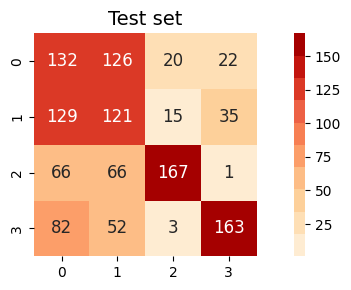

In [72]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test, y_test_pred_lr),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

**Curva ROC**

- In questo caso la curva ROC va a visualizzare la curva sul rapporto tra True Positive e False Positive e la cui area sotto la curva (AUC) rappresenta una misura di qualità della predizione

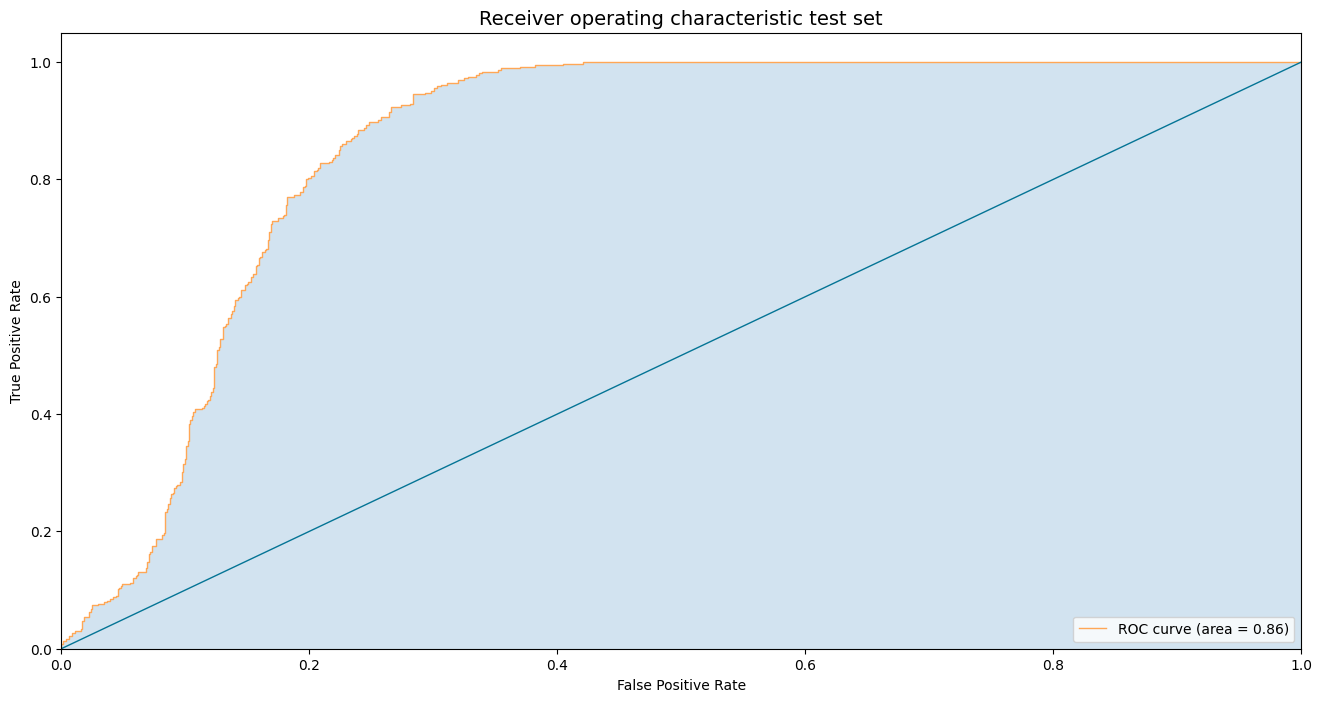

In [73]:
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = plt.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.35, 0.95, 256)))

fpr, tpr, thresholds = roc_curve(y_test_pred_lr, gs_lr.predict_proba(X_test_pca)[:,1], pos_label=1)
plt.figure(figsize=(16,8))
plt.plot(fpr, tpr, color=colors[0], linewidth=1,label='ROC curve (area = %0.2f)' %  auc(fpr, tpr))
plt.fill_between(fpr, 0, tpr, alpha=0.2)
plt.plot([0, 1], [0, 1], color=colors[1], linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel(r'True Positive Rate')
plt.xlabel(r'False Positive Rate')
plt.title('Receiver operating characteristic test set', fontsize=14)
plt.legend(loc="lower right")
plt.show()

### *Support Vector Machines*

In [74]:
best_svm = gs_svm.best_estimator_
y_test_pred_svm = best_svm.predict(X_test_pca)
print("Val Acc:", accuracy_score(y_test, y_test_pred_svm))
print(classification_report(y_test, y_test_pred_svm, digits=3))

Val Acc: 0.85
              precision    recall  f1-score   support

           0      0.981     0.690     0.810       300
           1      0.753     0.927     0.831       300
           2      0.820     0.943     0.878       300
           3      0.916     0.840     0.877       300

    accuracy                          0.850      1200
   macro avg      0.868     0.850     0.849      1200
weighted avg      0.868     0.850     0.849      1200



**Confusion Matrix**

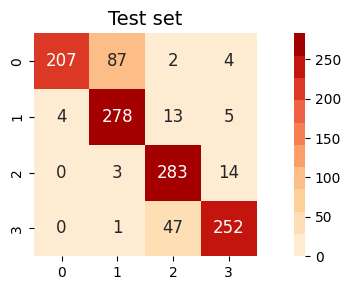

In [75]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test, y_test_pred_svm),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

### *Rete Neurale MLP*

In [76]:
best_mlp = gs_mlp.best_estimator_
y_test_pred_mlp = best_mlp.predict(X_test_pca)
print("Val Acc:", accuracy_score(y_test, y_test_pred_mlp))
print(classification_report(y_test, y_test_pred_mlp, digits=3))

Val Acc: 0.9433333333333334
              precision    recall  f1-score   support

           0      0.937     0.897     0.917       300
           1      0.901     0.937     0.918       300
           2      0.949     0.990     0.969       300
           3      0.990     0.950     0.969       300

    accuracy                          0.943      1200
   macro avg      0.944     0.943     0.943      1200
weighted avg      0.944     0.943     0.943      1200



**Confusion Matrix**

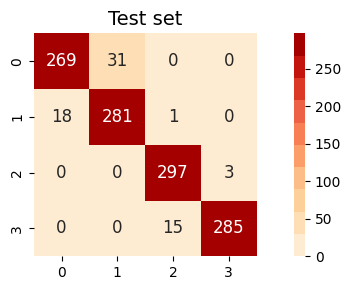

In [77]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,2)
hm = sns.heatmap(confusion_matrix(y_test, y_test_pred_mlp),cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Test di robustezza 


**Generazione primo dataset variato** con un maggiore rumore (1000,100,0.001)

In [45]:
X1, y1 = genera_campioni(n_shapes=1000, n_punti=100, rumore_std_bound=0.001)
X1_f = ottieni_features(X1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_f, y1, test_size=0.3)

**Generazione secondo dataset variato** con più esempi e features ma senza rumore (2000,200,0)

In [49]:
X2, y2 = genera_campioni(n_shapes=2000, n_punti=200, rumore_std_bound=0)
X2_f = ottieni_features(X2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_f, y2, test_size=0.3)

**Generazione terzo dataset variato** con molti meno esempi e features e molto più rumore (100,50,0.01)

In [52]:
X3, y3 = genera_campioni(n_shapes=100, n_punti=50, rumore_std_bound=0.01)
X3_f = ottieni_features(X3)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_f, y3, test_size=0.3)

In [ ]:
param_grid_mlp_alt2 = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['logistic'],
    'solver': ['sgd'],  # stochastic gradient descent
    'alpha': [0.001, 0.01, 0.1],    # moltiplicatore del fattore L2 di regolarizzazione per penalizzazione overfitting
    'learning_rate_init': [0.01, 0.1],
    'learning_rate': ['constant'], 
    'batch_size': [30, 50, 70],
    'max_iter': [100, 200, 300]
}

In [ ]:
gs_mlp_alt2 = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_mlp,
    cv=7,
    scoring='accuracy',
    n_jobs=-1,  # Usa tutti i core disponibili
)

Utilizzo di una pipeline con classificatore pari al migliore trovato per i dati precedenti

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()),('classifier', GridSearchCV(MLPClassifier(random_state=42),param_grid_mlp,cv=7,scoring='accuracy',n_jobs=-1))])

**Addestramento sul dataset con maggiore rumore**

In [47]:
pipe.fit(X1_train, y1_train)

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(100,)"
,activation,'logistic'
,solver,'sgd'
,alpha,0.001


In [48]:
out_test_1 = pipe.predict(X1_test)
print("Val Acc:", accuracy_score(y1_test, out_test_1))
print(classification_report(y1_test, out_test_1))

Val Acc: 0.9591666666666666
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       303
           1       0.94      0.94      0.94       300
           2       0.97      0.99      0.98       301
           3       0.99      0.97      0.98       296

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200



**Addestramento su dataset con più esempi e più features e senza rumore**

In [50]:
pipe.fit(X2_train, y2_train)

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(100,)"
,activation,'logistic'
,solver,'sgd'
,alpha,0.001


In [51]:
out_test_2 = pipe.predict(X2_test)
print("Val Acc:", accuracy_score(y2_test, out_test_2))
print(classification_report(y2_test, out_test_2))

Val Acc: 0.9370833333333334
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       614
           1       0.89      0.90      0.90       574
           2       0.97      0.98      0.97       589
           3       0.98      0.97      0.98       623

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



**Addestramento sul dataset con meno campioni e meno features e maggiore rumore**

In [53]:
pipe.fit(X3_train, y3_train)

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(100,)"
,activation,'logistic'
,solver,'sgd'
,alpha,0.001


In [54]:
out_test_3 = pipe.predict(X3_test)
print("Val Acc:", accuracy_score(y3_test, out_test_3))
print(classification_report(y3_test, out_test_3))

Val Acc: 0.7833333333333333
              precision    recall  f1-score   support

           0       0.67      0.77      0.72        31
           1       0.74      0.61      0.67        33
           2       0.83      0.87      0.85        23
           3       0.91      0.91      0.91        33

    accuracy                           0.78       120
   macro avg       0.79      0.79      0.79       120
weighted avg       0.79      0.78      0.78       120



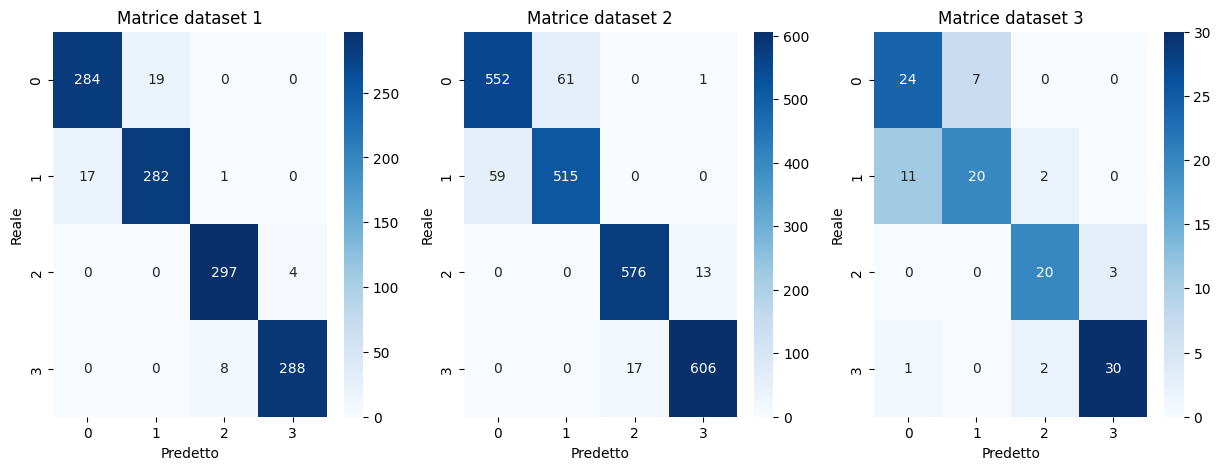

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
matrici = [
    confusion_matrix(y1_test, out_test_1),
    confusion_matrix(y2_test, out_test_2),
    confusion_matrix(y3_test, out_test_3)
]
for idx, cm in enumerate(matrici):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[idx])
    axs[idx].set_xlabel('Predetto')
    axs[idx].set_ylabel('Reale')
    axs[idx].set_title(f'Matrice dataset {idx + 1}')
